Installing the required models

In [463]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from numpy.random import seed
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

Read data from excel files

In [464]:
# Read data
# Here we are reading data from excel
gdp_data = pd.read_excel(
    "API_NY.GDP.MKTP.CD_DS2_en_excel_v2_6553527 - Copy.xls", sheet_name="Data")
diesel_demand = pd.read_excel(
    "Petrolem Demand.xlsx", sheet_name="Diesel_Finalized")
petrol_demand = pd.read_excel(
    "Petrolem Demand.xlsx", sheet_name="Petrol_Finalized")
gas_demand = pd.read_excel("Petrolem Demand.xlsx", sheet_name="LPG_Finalized")
parafin_demand = pd.read_excel("Petrolem Demand.xlsx", sheet_name="Paraffin_Finalized")
jet_demand = pd.read_excel("Petrolem Demand.xlsx", sheet_name="Jet A1_ Finalized")


Drops unwanted rows and re index

In [465]:
diesel_demand.columns = diesel_demand.iloc[0]
diesel_demand.drop(index=0, axis=0, inplace=True)

gas_demand.columns = gas_demand.iloc[0]
gas_demand.drop(index=0, axis=0, inplace=True)

petrol_demand.columns = petrol_demand.iloc[0]
petrol_demand.drop(index=0, axis=0, inplace=True)

parafin_demand.columns = parafin_demand.iloc[0]
parafin_demand.drop(index=0, axis=0, inplace=True)

jet_demand.columns =jet_demand.iloc[0]
jet_demand.drop(index=0, axis=0, inplace=True)

In [466]:
gdp_data.columns = gdp_data.iloc[2]
gdp_data.drop(index=[0, 1, 2], axis=0, inplace=True)

Drop unncessary information from gdp data

In [467]:

zwe_gdp = gdp_data[gdp_data['Country Code'] == "ZWE"]
zwe_gdp = zwe_gdp.drop(columns=['Country Name',   'Country Code', 'Indicator Name', 'Indicator Code',
                                1960.0,           1961.0,           1962.0,           1963.0,
                                1964.0,           1965.0,           1966.0,           1967.0,
                                1968.0,           1969.0,           1970.0,           1971.0,
                                1972.0,           1973.0,           1974.0,           1975.0,
                                1976.0,           1977.0,           1978.0,           1979.0,
                                1980.0,           1981.0,           1982.0,           1983.0,
                                1984.0,           1985.0,           1986.0,           1987.0,
                                1988.0,           1989.0,           1990.0,           1991.0,
                                1992.0,           1993.0,           1994.0,           1995.0,
                                1996.0,           1997.0,           1998.0,           1999.0,
                                2000.0,           2001.0,           2002.0,           2003.0,
                                2004.0,           2005.0,           2006.0,           2007.0,
                                2008.0], axis=1)

In [468]:
zwe_gdp.dropna(inplace=True, axis=1)

In [469]:

zwe_gdp[2023] = np.mean(np.array(zwe_gdp))

Transform data into appropriate format

In [470]:
def get_data(data, product, _data=pd.DataFrame({'Date': [], "Product": [], "GDP": [], "Demand": []})):
    cols = data['Year']
    for year in cols:
        demand = data[data['Year'] == year]
        if year != 'Grand Total':
            for month in demand.columns:
                if (month != "Year") and (month != "Grand Total"):
                    new_row = {'Date': f"01 {month} {year}", "Product": product, "GDP": zwe_gdp[int(
                        year)].values[0], 'Demand': demand[month].values[0]}
                    _data.loc[len(_data)] = new_row
    return _data


data = get_data(diesel_demand, "Diesel")
data=get_data(gas_demand,"Gas",data)
data=get_data(parafin_demand,"Parafin",data)
data=get_data(jet_demand,"Jet",data)
data = get_data(petrol_demand, "Petrol_demand", data)

#Each month hav got average for that year
data['GDP'] = data['GDP']/12

Draw graphs to understand the relationships btwn the dependent and independent

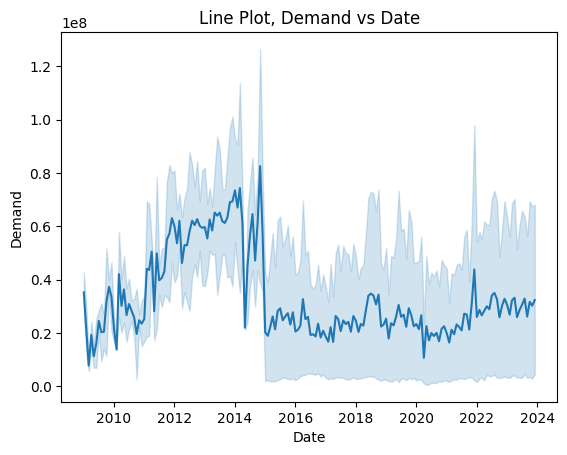

In [481]:
data['Date'] = pd.to_datetime(data['Date'])
# plt.figure(figsize=(15, 10))
sns.lineplot(data,y='Demand',x="Date")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
plt.title('Line Plot, Demand vs Date')
plt.show()

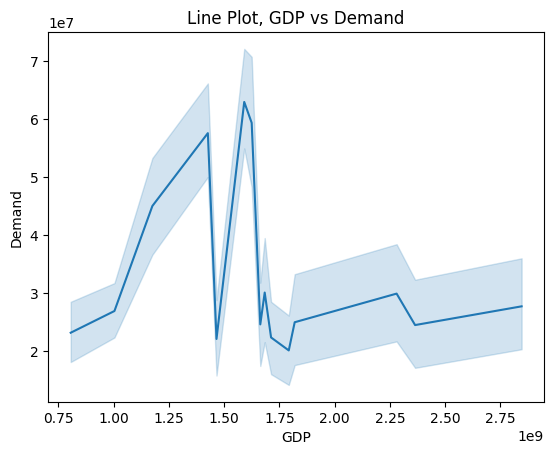

In [472]:

sns.lineplot(data,y='Demand',x="GDP")
plt.title('Line Plot, GDP vs Demand')
plt.show()


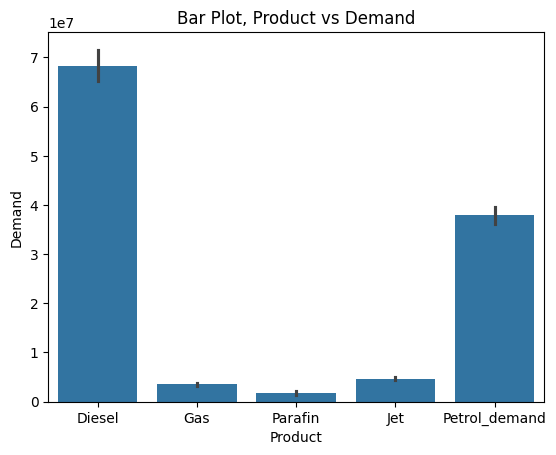

In [473]:

sns.barplot(data,y='Demand',x="Product")
plt.title('Bar Plot, Product vs Demand')
plt.show()

Encode Product Values into numeric

In [474]:
data['Product'] = data['Product'].astype('category').cat.codes

In [475]:

#Change date to numeric
data['Date'] = pd.to_numeric(data['Date'])



X = data.iloc[:, :-1]
Y = data.iloc[:, -1]
Y = np.array(Y)
X = np.array(X)


#Scale data into values between 0 and 1
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled=x_scaler.fit_transform(np.array(X))
y_scaled=y_scaler.fit_transform(np.array(Y.reshape(-1,1)))


#Split into train and test
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y_scaled, test_size=0.2)


y_test_actual=pd.DataFrame(y_scaler.inverse_transform(y_test.reshape(-1,1)),columns=['Demand'])
y_test=y_test.ravel()

Random Forest-Model

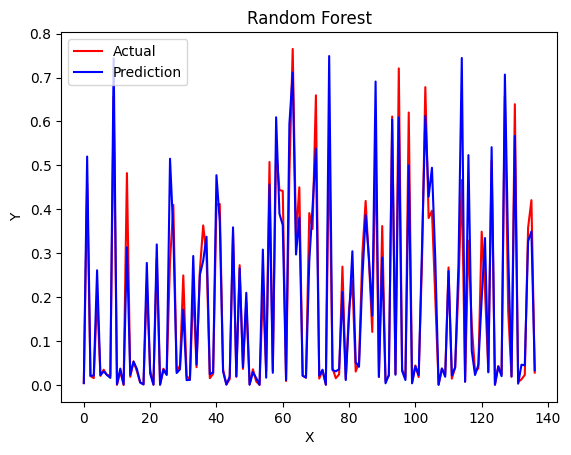

0.9125003783418308

In [476]:

random_forest_model = RandomForestRegressor(
    n_estimators=200, criterion="poisson")
random_forest_model.fit(x_train,y_train.ravel())
random_forest_predict = random_forest_model.predict(x_test)
plt.plot(y_test, label='Actual', color='red')
plt.plot(random_forest_predict, label='Prediction', color='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Random Forest')
plt.show()
score = r2_score(y_test, random_forest_predict)
score

GradientBoostingRegressor

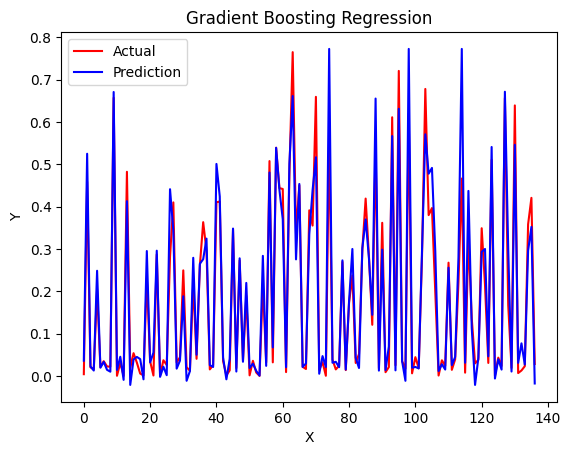

0.9253791256006374

In [477]:
gradient_boosting_model = GradientBoostingRegressor(
    n_estimators=207, loss="squared_error", alpha=0.01)
gradient_boosting_model.fit(x_train, y_train.ravel())
gradient_boosting_predict = gradient_boosting_model.predict(x_test)

plt.plot(y_test, label='Actual', color='red')
plt.plot(gradient_boosting_predict, label='Prediction', color='blue')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Gradient Boosting Regression')
plt.show()
r2_score(y_test, gradient_boosting_predict)

In [478]:
gb_pred_actual=pd.DataFrame(y_scaler.inverse_transform(gradient_boosting_predict.reshape(-1,1)),columns=['Demand'])
gb_pred_actual=gb_pred_actual.map('{:.0f}'.format)
gb_pred_actual = gb_pred_actual.apply(pd.to_numeric)

In [479]:
r2_score(y_test_actual,gb_pred_actual)

0.925379124787977